<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 3855, '日付': '2022-03-21T08:00:00.000Z'},
 {'小計': 3533, '日付': '2022-03-22T08:00:00.000Z'},
 {'小計': 6430, '日付': '2022-03-23T08:00:00.000Z'},
 {'小計': 8875, '日付': '2022-03-24T08:00:00.000Z'},
 {'小計': 7289, '日付': '2022-03-25T08:00:00.000Z'},
 {'小計': 7440, '日付': '2022-03-26T08:00:00.000Z'},
 {'小計': 7844, '日付': '2022-03-27T08:00:00.000Z'},
 {'小計': 4544, '日付': '2022-03-28T08:00:00.000Z'},
 {'小計': 7846, '日付': '2022-03-29T08:00:00.000Z'},
 {'小計': 9520, '日付': '2022-03-30T08:00:00.000Z'},
 {'小計': 8226, '日付': '2022-03-31T08:00:00.000Z'},
 {'小計': 7982, '日付': '2022-04-01T08:00:00.000Z'},
 {'小計': 7395, '日付': '2022-04-02T08:00:00.000Z'},
 {'小計': 7899, '日付': '2022-04-03T08:00:00.000Z'},
 {'小計': 4384, '日付': '2022-04-04T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-03-31 17:00:00+09:00,598,0,8226,2022-03-31 17:00:00+09:00
2022-04-01 17:00:00+09:00,604,0,7982,2022-04-01 17:00:00+09:00
2022-04-02 17:00:00+09:00,785,0,7395,2022-04-02 17:00:00+09:00
2022-04-03 17:00:00+09:00,562,0,7899,2022-04-03 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-03-31 17:00:00+09:00,598,0,8226,2022-03-31 17:00:00+09:00,597.285714,4181.0,0.0,0.0,7529.857143,52709.0
2022-04-01 17:00:00+09:00,604,0,7982,2022-04-01 17:00:00+09:00,613.142857,4292.0,0.0,0.0,7628.857143,53402.0
2022-04-02 17:00:00+09:00,785,0,7395,2022-04-02 17:00:00+09:00,630.142857,4411.0,0.0,0.0,7622.428571,53357.0
2022-04-03 17:00:00+09:00,562,0,7899,2022-04-03 17:00:00+09:00,625.142857,4376.0,0.0,0.0,7630.285714,53412.0
2022-04-04 17:00:00+09:00,0,0,4384,2022-04-04 17:00:00+09:00,533.857143,3737.0,0.0,0.0,7607.428571,53252.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-03-21 17:00:00+09:00,643,0,3855,2022-03-21 17:00:00+09:00,584.857143,4094.0,0.0,0.0,7449.142857,52144.0,'22w12,Mon
2022-03-22 17:00:00+09:00,654,0,3533,2022-03-22 17:00:00+09:00,587.285714,4111.0,0.0,0.0,6834.428571,47841.0,'22w12,Tue
2022-03-23 17:00:00+09:00,524,0,6430,2022-03-23 17:00:00+09:00,574.857143,4024.0,0.0,0.0,6292.857143,44050.0,'22w12,Wed
2022-03-24 17:00:00+09:00,494,0,8875,2022-03-24 17:00:00+09:00,571.714286,4002.0,0.0,0.0,6352.000000,44464.0,'22w12,Thu
2022-03-25 17:00:00+09:00,493,0,7289,2022-03-25 17:00:00+09:00,572.571429,4008.0,0.0,0.0,6275.428571,43928.0,'22w12,Fri
2022-03-26 17:00:00+09:00,666,0,7440,2022-03-26 17:00:00+09:00,573.428571,4014.0,0.0,0.0,6274.857143,43924.0,'22w12,Sat
2022-03-27 17:00:00+09:00,597,0,7844,2022-03-27 17:00:00+09:00,581.571429,4071.0,0.0,0.0,6466.571429,45266.0,'22w12,Sun
2022-03-28 17:00:00+09:00,639,0,4544,2022-03-28 17:00:00+09:00,581.000000,4067.0,0.0,0.0,6565.000000,45955.0,'22w13,Mon
2022-03-29 17:00:00+09:00,565,0,7846,2022-03-29 17:00:00+09:00,568.285714,3978.0,0.0,0.0,7181.142857,50268.0,'22w13,Tue
2022-03-30 17:00:00+09:00,623,0,9520,2022-03-30 17:00:00+09:00,582.428571,4077.0,0.0,0.0,7622.571429,53358.0,'22w13,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-03-20 17:00:00+09:00,7589.285714,53125
2022-03-27 17:00:00+09:00,6466.571429,45266
2022-04-03 17:00:00+09:00,7630.285714,53412
2022-04-04 17:00:00+09:00,4384.000000,4384
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-03-21 17:00:00+09:00,643,0,3855,2022-03-21 17:00:00+09:00,584.857143,4094.0,0.0,0.0,7449.142857,52144.0,'22w12,Mon,NaN,NaN
2022-03-22 17:00:00+09:00,654,0,3533,2022-03-22 17:00:00+09:00,587.285714,4111.0,0.0,0.0,6834.428571,47841.0,'22w12,Tue,NaN,NaN
2022-03-23 17:00:00+09:00,524,0,6430,2022-03-23 17:00:00+09:00,574.857143,4024.0,0.0,0.0,6292.857143,44050.0,'22w12,Wed,NaN,NaN
2022-03-24 17:00:00+09:00,494,0,8875,2022-03-24 17:00:00+09:00,571.714286,4002.0,0.0,0.0,6352.000000,44464.0,'22w12,Thu,NaN,NaN
2022-03-25 17:00:00+09:00,493,0,7289,2022-03-25 17:00:00+09:00,572.571429,4008.0,0.0,0.0,6275.428571,43928.0,'22w12,Fri,NaN,NaN
2022-03-26 17:00:00+09:00,666,0,7440,2022-03-26 17:00:00+09:00,573.428571,4014.0,0.0,0.0,6274.857143,43924.0,'22w12,Sat,NaN,NaN
2022-03-27 17:00:00+09:00,597,0,7844,2022-03-27 17:00:00+09:00,581.571429,4071.0,0.0,0.0,6466.571429,45266.0,'22w12,Sun,6466.571429,45266.0
2022-03-28 17:00:00+09:00,639,0,4544,2022-03-28 17:00:00+09:00,581.000000,4067.0,0.0,0.0,6565.000000,45955.0,'22w13,Mon,NaN,NaN
2022-03-29 17:00:00+09:00,565,0,7846,2022-03-29 17:00:00+09:00,568.285714,3978.0,0.0,0.0,7181.142857,50268.0,'22w13,Tue,NaN,NaN
2022-03-30 17:00:00+09:00,623,0,9520,2022-03-30 17:00:00+09:00,582.428571,4077.0,0.0,0.0,7622.571429,53358.0,'22w13,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

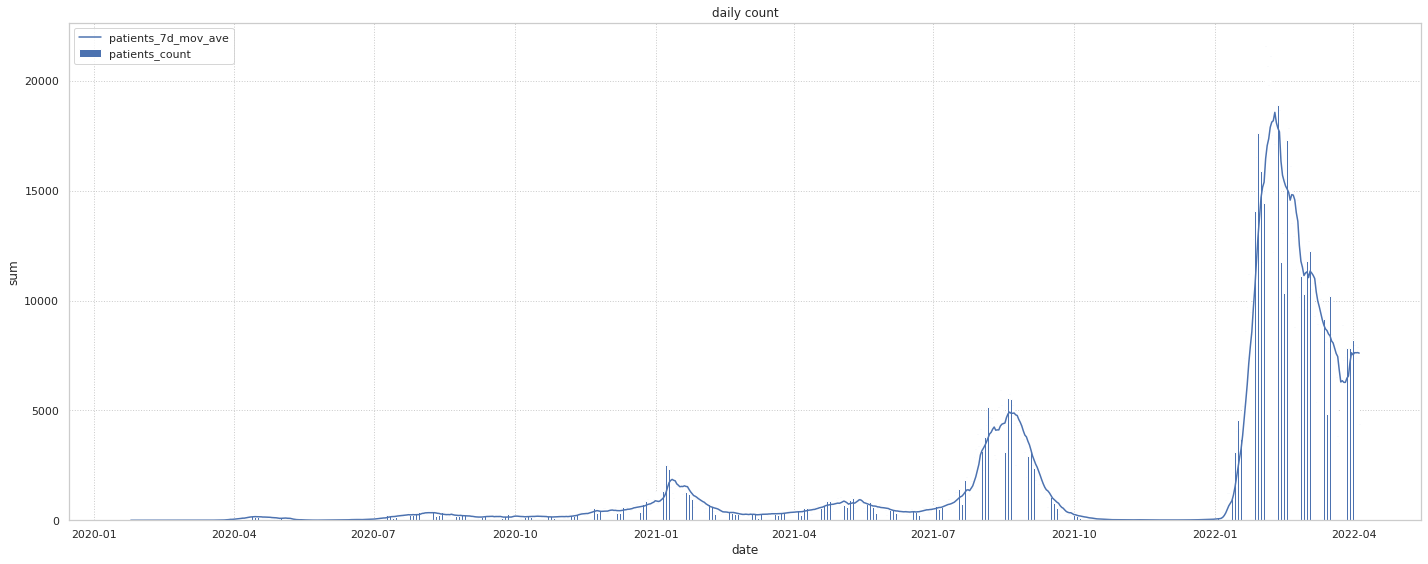

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
787,1.647850e+09,2022,3,21,0,1,0,0,0,0,...,713,643,584.857143,4094.0,0,0.0,0.0,3855,7449.142857,52144.0
788,1.647936e+09,2022,3,22,0,0,0,0,0,1,...,714,654,587.285714,4111.0,0,0.0,0.0,3533,6834.428571,47841.0
789,1.648022e+09,2022,3,23,0,0,0,0,0,0,...,715,524,574.857143,4024.0,0,0.0,0.0,6430,6292.857143,44050.0
790,1.648109e+09,2022,3,24,0,0,0,0,1,0,...,716,494,571.714286,4002.0,0,0.0,0.0,8875,6352.000000,44464.0
791,1.648195e+09,2022,3,25,1,0,0,0,0,0,...,717,493,572.571429,4008.0,0,0.0,0.0,7289,6275.428571,43928.0
792,1.648282e+09,2022,3,26,0,0,1,0,0,0,...,718,666,573.428571,4014.0,0,0.0,0.0,7440,6274.857143,43924.0
793,1.648368e+09,2022,3,27,0,0,0,1,0,0,...,719,597,581.571429,4071.0,0,0.0,0.0,7844,6466.571429,45266.0
794,1.648454e+09,2022,3,28,0,1,0,0,0,0,...,720,639,581.000000,4067.0,0,0.0,0.0,4544,6565.000000,45955.0
795,1.648541e+09,2022,3,29,0,0,0,0,0,1,...,721,565,568.285714,3978.0,0,0.0,0.0,7846,7181.142857,50268.0
796,1.648627e+09,2022,3,30,0,0,0,0,0,0,...,722,623,582.428571,4077.0,0,0.0,0.0,9520,7622.571429,53358.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802 entries, 0 to 801
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            802 non-null    float64
 1   year                 802 non-null    int64  
 2   month                802 non-null    int64  
 3   day                  802 non-null    int64  
 4   Fri                  802 non-null    uint8  
 5   Mon                  802 non-null    uint8  
 6   Sat                  802 non-null    uint8  
 7   Sun                  802 non-null    uint8  
 8   Thu                  802 non-null    uint8  
 9   Tue                  802 non-null    uint8  
 10  Wed                  802 non-null    uint8  
 11  passed               802 non-null    int64  
 12  emergency            802 non-null    int64  
 13  em_passed            802 non-null    int64  
 14  contacts_count       802 non-null    int64  
 15  contacts_7d_mov_ave  802 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,8.020000e+02,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,...,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000,802.000000
mean,1.614456e+09,2020.689526,6.158354,15.756858,0.143392,0.143392,0.143392,0.143392,0.142145,0.142145,...,329.960100,687.071072,685.365129,4797.551122,459.500000,459.500000,3216.500000,1593.903990,1568.025704,10976.159601
std,2.001558e+07,0.670115,3.501184,8.859113,0.350690,0.350690,0.350690,0.350690,0.349416,0.349416,...,226.320232,553.808950,541.673956,3791.723715,774.314326,712.119369,4984.835582,3561.278067,3468.034019,24276.247329
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.597154e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,126.250000,331.000000,334.035714,2338.250000,0.000000,0.000000,0.000000,59.250000,61.714286,432.000000
50%,1.614456e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,326.500000,519.000000,532.928571,3730.500000,0.000000,0.000000,0.000000,288.000000,289.785714,2028.500000
75%,1.631758e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,526.750000,840.500000,868.928571,6082.500000,931.750000,1025.214286,7176.500000,831.500000,784.107143,5488.750000
max,1.649059e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,727.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21562.000000,18562.285714,129936.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.900660,0.104981,0.001825,-0.002651,0.002651,-0.000884,0.000884,0.001758,-0.001758,...,0.998745,-0.023943,-0.013520,-0.013518,-0.618902,-0.664589,-0.664589,0.525768,0.532862,0.532864
year,9.006596e-01,1.000000,-0.336066,-0.033551,-0.001570,0.003743,0.003743,0.003743,-0.003231,-0.003231,...,0.906166,0.095036,0.105355,0.105357,-0.611381,-0.664777,-0.664777,0.644407,0.648775,0.648776
month,1.049811e-01,-0.336066,1.000000,-0.001977,-0.002248,-0.003265,-0.010382,-0.007332,0.011172,0.004029,...,0.089530,-0.272034,-0.271883,-0.271880,0.059039,0.083217,0.083217,-0.337222,-0.331159,-0.331158
day,1.824617e-03,-0.033551,-0.001977,1.000000,0.001190,0.005208,-0.002025,0.007619,0.001096,-0.004953,...,0.002379,0.018783,0.003158,0.003156,0.005114,-0.005143,-0.005143,-0.008076,-0.015911,-0.015912
Fri,-2.650809e-03,-0.001570,-0.002248,0.001190,1.000000,-0.167394,-0.167394,-0.167394,-0.166544,-0.166544,...,-0.002224,-0.017029,-0.001911,-0.001910,0.024181,-0.000984,-0.000984,0.018235,-0.000531,-0.000532
Mon,2.650809e-03,0.003743,-0.003265,0.005208,-0.167394,1.000000,-0.167394,-0.167394,-0.166544,-0.166544,...,0.002683,0.035206,-0.000646,-0.000645,0.098284,-0.000984,-0.000984,-0.060386,0.002354,0.002354
Sat,-8.836029e-04,0.003743,-0.010382,-0.002025,-0.167394,-0.167394,1.000000,-0.167394,-0.166544,-0.166544,...,-0.000588,0.045870,-0.001174,-0.001173,-0.115401,-0.000984,-0.000984,0.012973,0.000553,0.000553
Sun,8.836029e-04,0.003743,-0.007332,0.007619,-0.167394,-0.167394,-0.167394,1.000000,-0.166544,-0.166544,...,0.001047,-0.024068,-0.000646,-0.000645,-0.106394,-0.000984,-0.000984,-0.009408,0.001711,0.001711
Thu,1.758226e-03,-0.003231,0.011172,0.001096,-0.166544,-0.166544,-0.166544,-0.166544,1.000000,-0.165698,...,0.001335,-0.011955,0.002034,0.002035,0.030256,0.001317,0.001317,0.029160,-0.000093,-0.000093
Tue,-1.758226e-03,-0.003231,0.004029,-0.004953,-0.166544,-0.166544,-0.166544,-0.166544,-0.165698,1.000000,...,-0.001949,-0.016046,0.000884,0.000884,0.040929,0.001317,0.001317,-0.013870,-0.002705,-0.002705


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,1.648714e+09,0,0,0,0,1,0,0,797,0,723,598,0,8226,7529.857143,52709.0
798,1.648800e+09,1,0,0,0,0,0,0,798,0,724,604,0,7982,7628.857143,53402.0
799,1.648886e+09,0,0,1,0,0,0,0,799,0,725,785,0,7395,7622.428571,53357.0
800,1.648973e+09,0,0,0,1,0,0,0,800,0,726,562,0,7899,7630.285714,53412.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
797,1.648714e+09,797,0,8226,7529.857143,52709.0
798,1.648800e+09,798,0,7982,7628.857143,53402.0
799,1.648886e+09,799,0,7395,7622.428571,53357.0
800,1.648973e+09,800,0,7899,7630.285714,53412.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

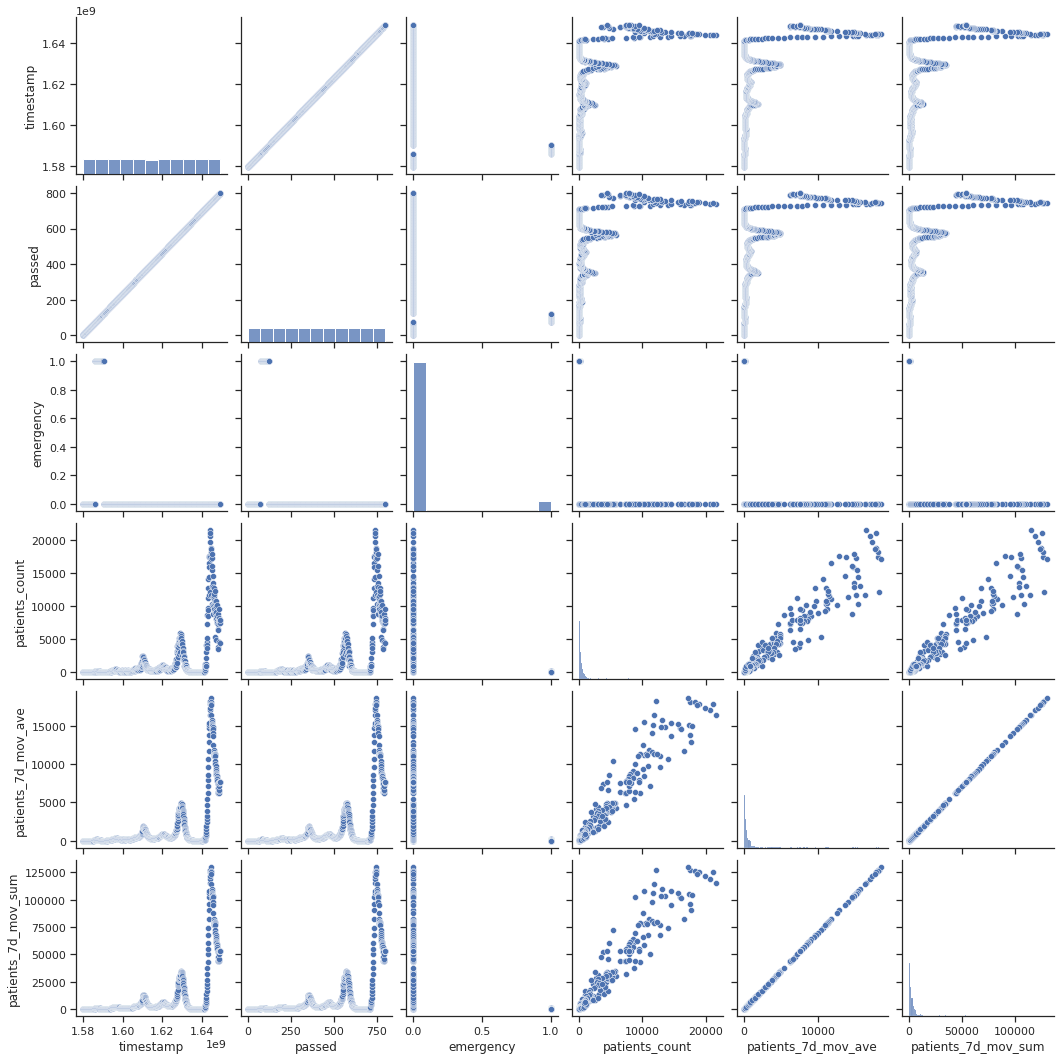

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.13


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==